This is the final notebook that produces the RABASAR (or multi-temporal despeckled) products. The main ingredients summarized are:

1. reading the time series of images as `time_series`.
2. reading the temporally averaged reference `temporal_average`.
3. Forming the ratios `ratios = [img / temporal_average for img in time_series]`.
4. Spatial de-speckling the ratio using the model from the [paper](https://ieeexplore.ieee.org/document/8602457) to obtain `ratio_despeckled`
5. Reconstructing the de-speckled images as `[ratio * temporal_average for ratio in ratios]`

The algorithm is summarized best from figure 1 from the paper above:

[![](https://weiyingzhao.github.io/images/flowchart2.png)](https://weiyingzhao.github.io//RABASAR/)


### Notes

+ We need to specify a weight for the denoised regularized temporally averaged reference image; this is how we will determine it's file name using a previous notebook.
+ We remind users that we have a single temporally average image for the entire time series since we do not perform change detection.
+ Note our "temporally averaged reference" is what the paper calls the "super-image."

In [1]:
import rasterio
import numpy
import scipy
from rabasar import (admm_ratio_denoise, 
                     interpolate_nn, 
                     get_enl_img, 
                     get_enl_mode, 
                     get_enl_mask,
                     scale_img)
from itertools import starmap
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# Read Config File

In [2]:
config_dict = json.load(open('config.json', 'r'))
config_dict

{'sensor': 'alos1',
 'site': 'waxlake',
 'regularizer': 'bm3d',
 'spatial_weight': 0.05,
 'temporal_average_spatial_weight': 0.005,
 'ratio_weight': 0.05}

In [3]:
SENSOR = config_dict['sensor']
SITE = config_dict['site']
REGULARIZER = config_dict['regularizer']
TA_SPATIAL_WEIGHT = config_dict['temporal_average_spatial_weight']

# Data Paths

In [4]:
ta_image_dir_name = f'out/{SENSOR}_{SITE}_{REGULARIZER}/temporally_averaged_image_{REGULARIZER}/weight_{TA_SPATIAL_WEIGHT:1.3f}'
TEMPORALLY_AVERAGED_IMAGE_DIR_TV = Path(ta_image_dir_name)
TEMPORALLY_AVERAGED_IMAGE_DIR_TV.exists()

True

In [5]:
data_dir_path_name = f'{SENSOR}_{SITE}/data_reprojected'
DATA_DIR = Path(data_dir_path_name)
DATA_DIR.exists()

True

In [6]:
RATIO_DIR =Path(f'out/{SENSOR}_{SITE}_{REGULARIZER}/rabasar_{REGULARIZER}')
RATIO_DIR.mkdir(exist_ok=True, parents=True)

In [7]:
hh_paths = sorted(list(DATA_DIR.glob('*/*hh*.tif')))
hv_paths = sorted(list(DATA_DIR.glob('*/*hv*.tif')))
if SENSOR == 'uavsar':
    vv_paths = sorted(list(DATA_DIR.glob('*/*vv*.tif')))

hv_paths

[PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20071015.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20080601.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20080717.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20080901.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20081017.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20090720.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20091020.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20100607.tif'),
 PosixPath('alos1_waxlake/data_reprojected/hv/alos1_waxlake_hv_RTC_20101208.tif')]

In [8]:
ta_tv_paths = sorted(list(TEMPORALLY_AVERAGED_IMAGE_DIR_TV.glob('*.tif')))
ta_tv_paths

[PosixPath('out/alos1_waxlake_bm3d/temporally_averaged_image_bm3d/weight_0.005/waxlake_alos1_temporally_average_hh_bm3d_0.005.tif'),
 PosixPath('out/alos1_waxlake_bm3d/temporally_averaged_image_bm3d/weight_0.005/waxlake_alos1_temporally_average_hv_bm3d_0.005.tif')]

# Opening data

In [9]:
def open_one(path):
    with rasterio.open(path) as ds:
        img = ds.read(1)
    return img

ta_tv_reference_images = list(map(open_one, ta_tv_paths))

In [10]:
with rasterio.open(ta_tv_paths[0]) as ds:
    profile = ds.profile

# Subset and Display

In [11]:
if SITE == 'waxlake' and SENSOR == 'uavsar' and REGULARIZER == 'tv':
    sy = np.s_[-2000:-1000]
    sx = np.s_[-3000:-2000]
elif SITE == 'waxlake' and SENSOR == 'alos1' and REGULARIZER == 'tv':
    sy = np.s_[3_900:4_900]
    sx = np.s_[2_800:3_800]
elif REGULARIZER == 'bm3d':
    sy = sx = np.s_[:]
else:
    raise NotImplementedError

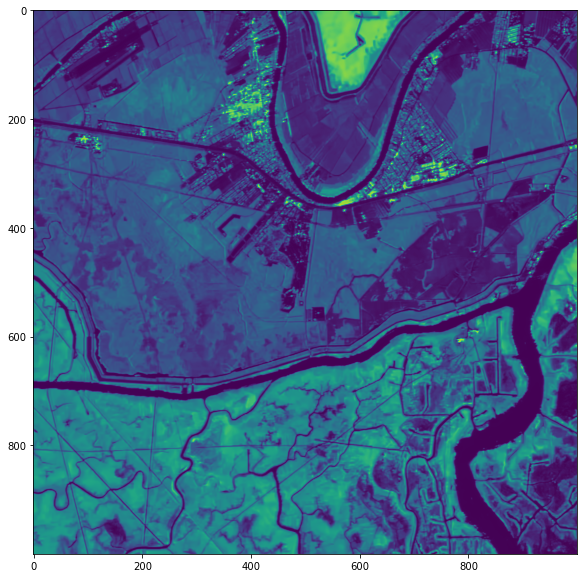

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(ta_tv_reference_images[0][sy, sx])

In [13]:
def read_arr(path):
    with rasterio.open(path) as ds:
        arr = ds.read(1)
    arr = np.clip(arr, 0, 1)
    return arr
hh_ts = list(map(read_arr, hh_paths))
hv_ts = list(map(read_arr, hv_paths))
if SENSOR == 'uavsar':
    vv_ts = list(map(read_arr, vv_paths))

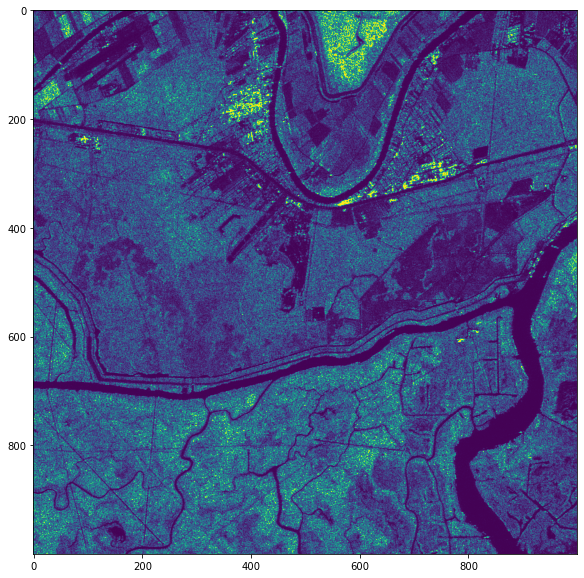

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(hh_ts[0][sy, sx])

## Reading the Temporally Averaged Reference Images

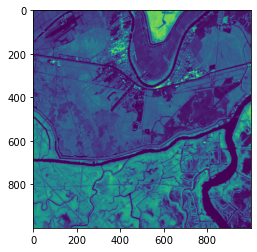

In [15]:
ta_reference_image_hh = np.clip(ta_tv_reference_images[0],  1e-5, 1)
ta_reference_image_hv = np.clip(ta_tv_reference_images[0],  1e-5, 1)
if SENSOR == 'uavsar':
    ta_reference_image_vv = np.clip(ta_tv_reference_images[0],  1e-5, 1)
plt.imshow(ta_reference_image_hh[sy, sx])

# Forming the Ratio Images

In [16]:
def ratio_hh(img):
    return np.clip(img / ta_reference_image_hh, 1e-3, 10)
def ratio_hv(img):
    return np.clip(img / ta_reference_image_hv, 1e-3, 10)
def ratio_vv(img):
    return np.clip(img / ta_reference_image_vv, 1e-3, 10)

ratio_hh_ts = list(map(ratio_hh, tqdm(hh_ts)))
ratio_hv_ts = list(map(ratio_hv, tqdm(hv_ts)))
if SENSOR == 'uavsar':
    ratio_vv_ts = list(map(ratio_vv, tqdm(vv_ts)))

100%|██████████| 9/9 [00:00<00:00, 308.52it/s]


We fill in the nodata areas (`np.nan`) with their nearest neighbor value to allow the spatial despeckler to work.

In [17]:
ratio_hh_ts_nn = list(map(interpolate_nn, tqdm(ratio_hh_ts)))
ratio_hv_ts_nn = list(map(interpolate_nn, tqdm(ratio_hv_ts)))
if SENSOR == 'uavsar':
    ratio_vv_ts_nn = list(map(interpolate_nn, tqdm(ratio_vv_ts)))

100%|██████████| 9/9 [00:00<00:00, 17.08it/s]


Let's see what the ratio images look like.

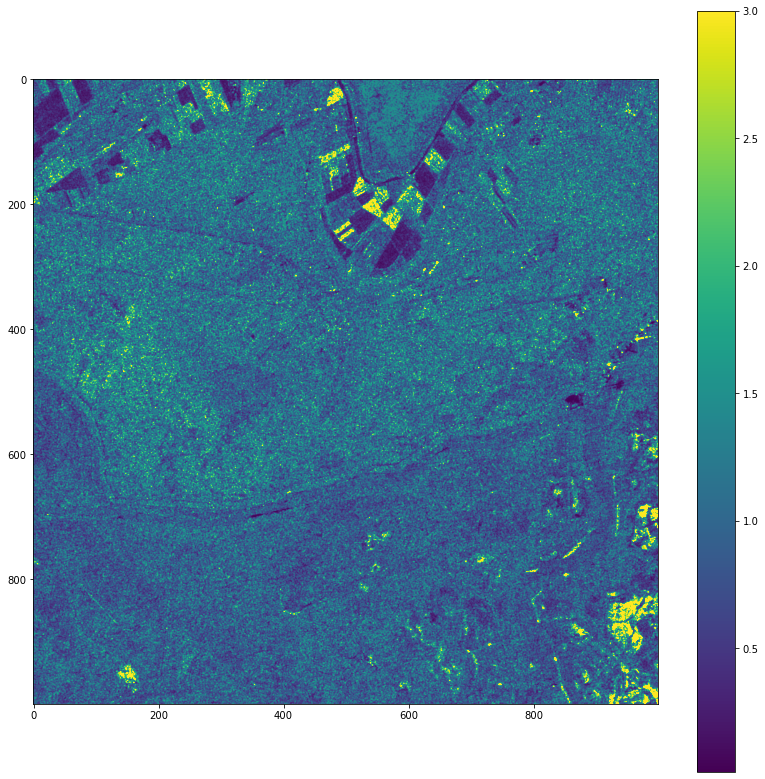

In [18]:
plt.figure(figsize=(14, 14))
plt.imshow(ratio_hh_ts[-1][sy, sx], vmax=3)
plt.colorbar()

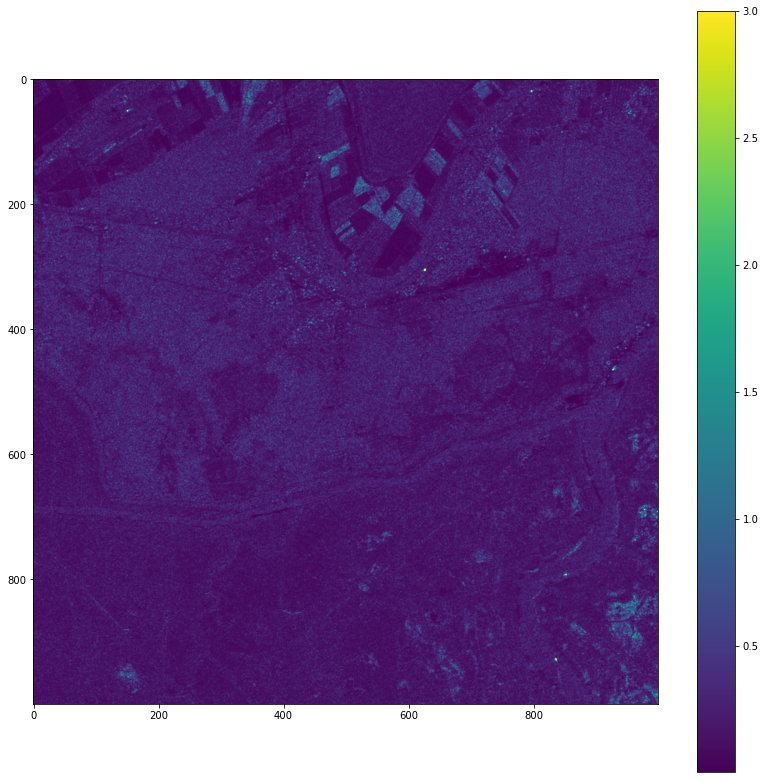

In [19]:
plt.figure(figsize=(14, 14))
plt.imshow(ratio_hv_ts[-1][sy, sx], vmax=3)
plt.colorbar()

# Spatial Despeckling of Ratios

We now perform the spatial de-speckling of the ratios.

## Computing the ENL's

For both the temporal average and the original image. We need both for the de-speckling algorithm.

In [20]:
mask_c = np.isnan(hh_ts[0][sy, sx])
img_c = hh_ts[0][sy, sx]
ta_ref_c = ta_reference_image_hh[sy, sx]
enl_mask = get_enl_mask(img_c, db_min=-13)

In [21]:
enl_img = get_enl_img(img_c, 31, enl_max=20, mask=enl_mask)
L = round(get_enl_mode(enl_img))

# We increase the max because the smoothing of the super image using TV will greatly increase this.
# You could still use the unsmoothed temporal average, too, if the results are not reasonable
enl_img_ta = get_enl_img(ta_ref_c, 31, enl_max=1_000, mask=enl_mask)
Lm = round(get_enl_mode(enl_img_ta))

L, Lm

(3, 20)

Text(0, 0.5, 'frequency')

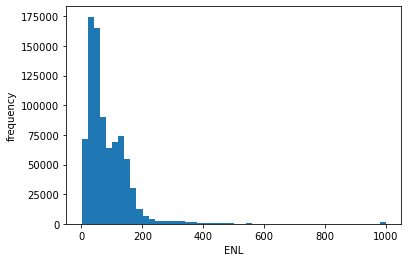

In [22]:
plt.hist(enl_img_ta[~np.isnan(enl_img_ta)], bins=50)
plt.xlabel('ENL')
plt.ylabel('frequency')

## Testing the Despeckling on a Subset

In [23]:
ratio_filled_c = ratio_hh_ts_nn[0][sy, sx]

For both, regularizers, we found that the denoising of ratio looked reasonable if it was set to the weight used during the spatial denoising.

In [24]:
if REGULARIZER == 'tv':
    regularizer_dict = {
                         'weight': 1
                        }
    
elif REGULARIZER == 'bm3d':
    regularizer_dict = {
                         'weight': .05
                        }
else:
    pass

In [25]:
ratio_den, res_list = admm_ratio_denoise(ratio_filled_c,
                                         L,
                                         Lm,
                                         REGULARIZER,
                                         regularizer_dict, 
                                         max_admm_iterations=10,
                                         newton_iterations=3
                                         )
ratio_den[mask_c] = np.nan

admm_iterations: 100%|██████████| 10/10 [04:25<00:00, 26.53s/it]


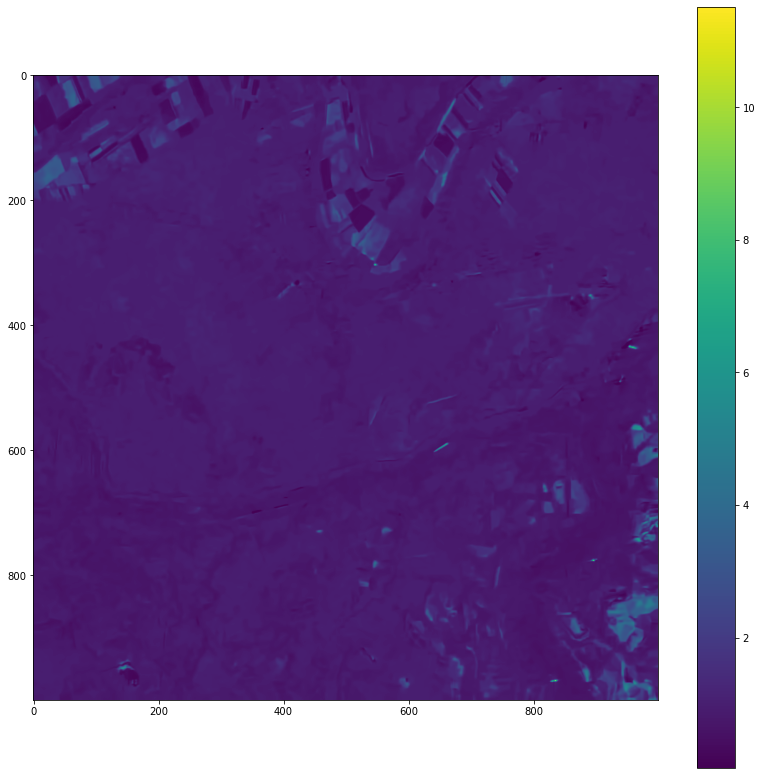

In [26]:
plt.subplots(figsize=(14, 14))
plt.imshow(ratio_den)
plt.colorbar()

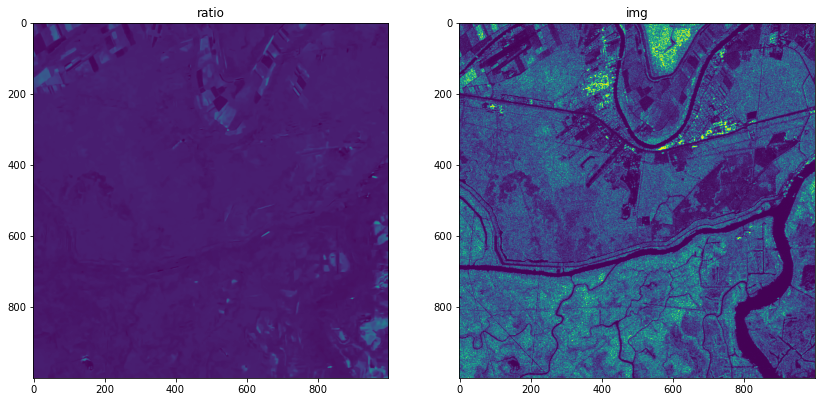

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(14, 14))
axs[0].imshow(ratio_den)
axs[0].set_title('ratio')
axs[1].set_title('img')
axs[1].imshow(img_c)

Text(0.5, 0, 'ADMM Iterations')

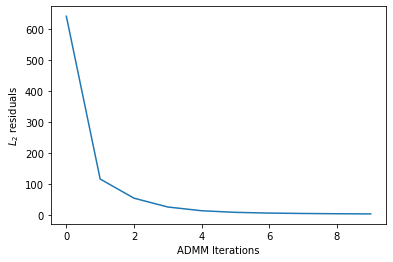

In [28]:
n = len(res_list)
plt.plot(np.arange(n), res_list)
plt.ylabel('$L_2$ residuals')
plt.xlabel('ADMM Iterations')

## Inspecting the Final Image

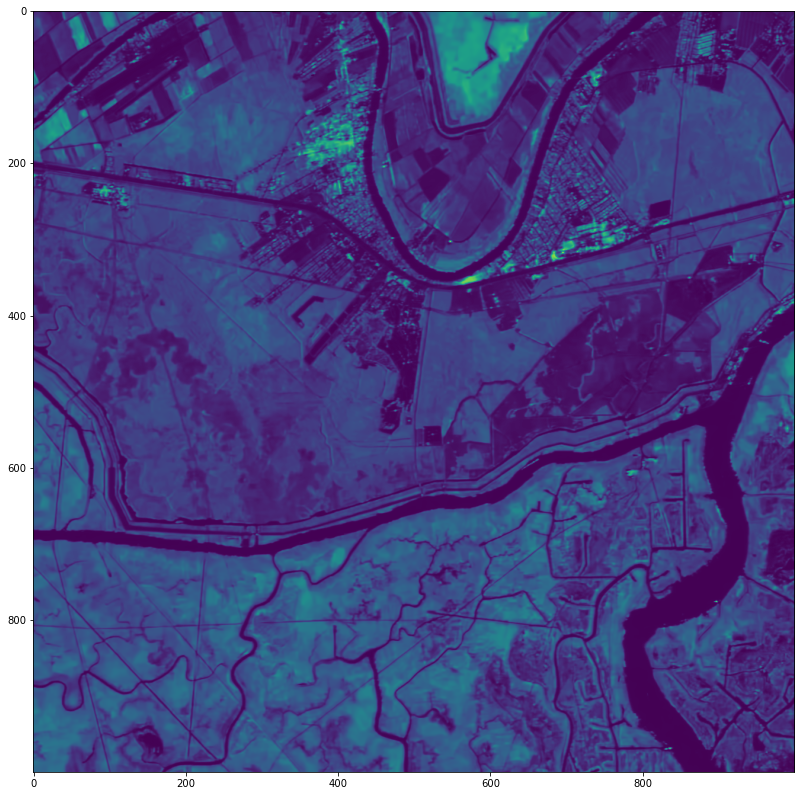

In [29]:
plt.subplots(figsize=(14, 14))
X_den = ratio_den * ta_ref_c
plt.imshow(X_den)

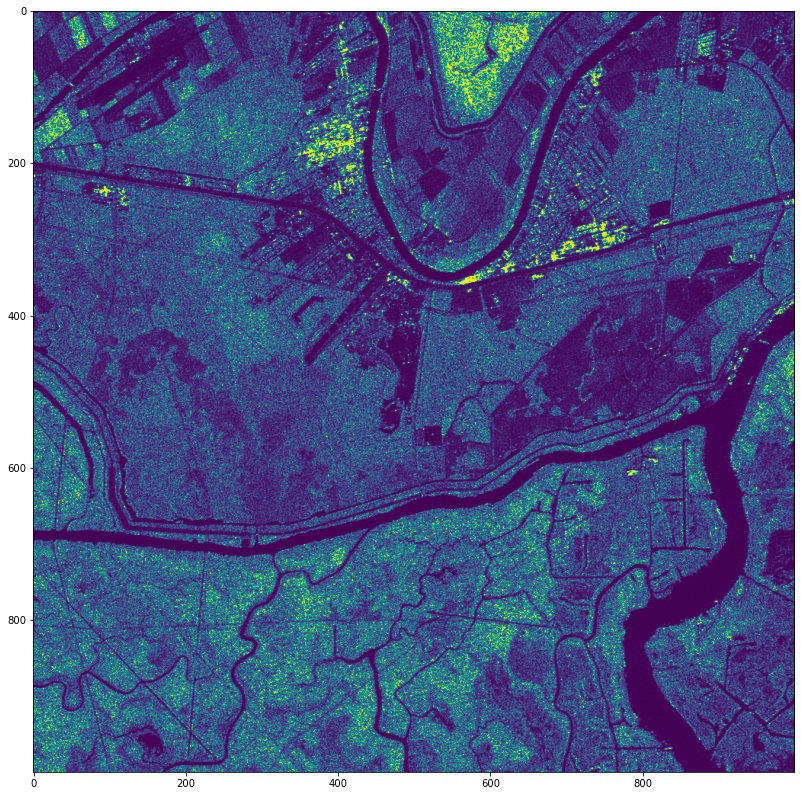

In [30]:
plt.subplots(figsize=(14, 14))
plt.imshow(img_c)

# Despeckle the Full Area and the Full Time Series

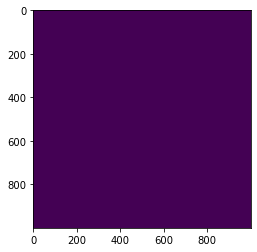

In [31]:
mask = np.isnan(hh_ts[0])
plt.imshow(mask)

In [40]:
def denoise_and_write_one_ratio_image(ratio, file_name, pol, ratio_weight):
    
    if pol == 'hh':
        ta_reference = ta_reference_image_hh
    if pol == 'hv':
        ta_reference = ta_reference_image_hv
    if pol == 'vv':
        ta_reference = ta_reference_image_vv
    
    regularizer_dict = {
                         'weight': ratio_weight
                        }
    
    ratio_den, res_list = admm_ratio_denoise(ratio,
                                             L,
                                             Lm,
                                             REGULARIZER,
                                             regularizer_dict, 
                                             max_admm_iterations=10,
                                             newton_iterations=3
                                             )
    
    despeckled_final = ratio_den * ta_reference
    despeckled_final = np.clip(despeckled_final, 1e-3, 1)
    despeckled_final[mask] = np.nan
    ratio_den[mask] = np.nan
    
    dest_dir_ratio = Path(f'{str(RATIO_DIR)}')/f'ratio_weight_{ratio_weight:1.3f}'/pol
    dest_dir_ratio.mkdir(exist_ok=True, parents=True)
    
    dest_dir_final = Path(f'{str(RATIO_DIR)}')/f'final_weight_{ratio_weight:1.3f}'/pol
    dest_dir_final.mkdir(exist_ok=True, parents=True)
    
    dest_ratio_path = dest_dir_ratio/file_name.replace('.tif', f'_weight_{ratio_weight:1.3f}.tif')
    with rasterio.open(dest_ratio_path, 'w', **profile) as ds:
         ds.write(ratio_den.astype(np.float32), 1)
        
    dest_final_path = dest_dir_final/file_name.replace('.tif', f'_{REGULARIZER}_weight_{ratio_weight:1.3f}.tif')
    with rasterio.open(dest_final_path, 'w', **profile) as ds:
        ds.write(despeckled_final.astype(np.float32), 1)
    return dest_ratio_path, dest_final_path

In [41]:
hh_names = list(map(lambda x: x.name, hh_paths))
hv_names = list(map(lambda x: x.name, hv_paths))
if SENSOR == 'uavsar':
    vv_names = list(map(lambda x: x.name, vv_paths))

n = len(hv_names)

In [42]:
RATIO_WEIGHT  = config_dict['ratio_weight']

list(starmap(denoise_and_write_one_ratio_image, zip(tqdm(ratio_hh_ts_nn), hh_names, ['hh'] * n, [RATIO_WEIGHT] * n)))
list(starmap(denoise_and_write_one_ratio_image, zip(tqdm(ratio_hv_ts_nn), hv_names, ['hv'] * n, [RATIO_WEIGHT] * n)))
if SENSOR == 'uavsar':
    list(starmap(denoise_and_write_one_ratio_image, zip(tqdm(ratio_vv_ts_nn), vv_names, ['vv'] * n, [RATIO_WEIGHT] * n)))

admm_iterations:  40%|████      | 4/10 [01:39<02:28, 24.74s/it]


100%|██████████| 9/9 [40:02<00:00, 266.92s/it]
